# Atividade 01: Rede Neural Profunda 

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Nos trabalhos anteriores, você implementou uma rede neural de duas camadas completamente conectadas sobre a base de dados CIFAR-10. A implementação era simples porém não era modular, visto que a perda e o gradiente foram calculados em uma única função `monolítica`. Isto é viável para uma rede simples de duas camadas, mas seria impraticável na medida que os modelos se tornem maiores. A forma ideal seria construir redes por meio de um projeto mais modular em que fosse possível implementar diferentes tipos de camadas de modo isolado e então combiná-las em novos modelos com diferentes arquiteturas.

Nessa atividade, você irá construir redes completamente conectadas usando uma abordagem mais modular. Para cada camada, você deverá implementar uma função denominada `forward` e outra `backward`. A função `forward` irá receber as entradas, pesos e demais parâmetros e retornará, além da saída, um objeto `cache` contendo os dados necessários para realização do *backward pass*, como no seguinte exemplo:

```python
def layer_forward(x, w):
  """ Recebe entradas x e pesos w """
  # Realiza alguns cálculos ...
  z = # ... produz alguns resultados intermediários
  # Realiza mais alguns cálculos ...
  out = # gera a saída
   
  cache = (x, w, z, out) # Guarda valores necessários para o cálculo de gradientes
   
  return out, cache
```

O *backward pass* irá receber como entrada as derivadas *upstream* e o objeto `cache` e deverá retornar os gradientes em relação as entradas e pesos, como no seguinte exemplo:

```python
def layer_backward(dout, cache):
  """
  Recebe derivada da perda em relação às saídas e o objeto cache
  e calcula as derivadas em relação às entradas.
  """
  # Recupera valores guardados a partir do objeto cache
  x, w, z, out = cache
  
  # Usa valores para cálculo das derivadas
  dx = # Derivadas da perda em relação a x
  dw = # Derivadas da perda em relação a w
  
  return dx, dw
```

Depois de se implementar uma série de camadas dessa forma, você será capaz de facilmente combiná-las para construir modelos com diferentes arquiteturas.

Além de implementar redes completamente conectadas com profundidade arbitrária, você irá também exploara diferentes regras de atualização para otimização, além de utilizar *Dropout* como técnica para regularização e *Batch normalization* como ferramenta para tornar mais eficiente a otimização de redes profundas.
  

In [1]:
# Executa algum código de inicialização desse notebook.

from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from dl.classifiers.fc_net import *
from dl.data_utils import get_CIFAR10_data
from dl.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório 'dl/datasets/cifar-10-batches-py'

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Camada Afim: *foward pass*

Uma camada afim (ou polinomial do primeiro grau) realiza uma transformações lineares seguidas de  translações, isto é, $\mathbb{x}\; \mathbb{w} + \mathbb{b}$. 

Abra o arquivo `dl/layers.py` e implemente a função `affine_forward`.

Em seguida, você pode testar sua implementação utilizando o trecho de código abaixo:

In [3]:
# Teste para a função affine_forward

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare seu resultado com o resultado correto que foi fornecido. 
# O erro deve estar em cerca de 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.7698500479884e-10


# Camada Afim: *backward pass*

Agora, você deve implementar a função `affine_backward` e testá-la utilizando verificação numérica do gradiente.

In [4]:
# Teste para a função affine_backward
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# Os erros devem estar em torno de 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# Camada ReLU: *forward pass*

Uma camada ReLU utiliza de unidades lineares rectificadas para produzir suas saídas, isto é, $\max\{0, \mathbb{x}\}$.

Você deve implementar a função de ativação (*forward pass*) para camada ReLU na função  `relu_forward` e, em seguida, testá-la usando o seguinte código:

In [5]:
# Teste para a função relu_forward

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare seu resultado com o resultado correto que foi fornecido. 
# O erro deve estar em cerca de 5e-8.
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# Camada ReLU: *backward pass*

Agora você deve implementar o *backward pass* para a camada ReLU na função `relu_backward` e testar sua implementação usando verificação numérica do gradiente:

In [6]:
# Teste para a função relu_backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# O erro deve estar em torno de 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" de Camadas

Existem alguns padrões de combinação de camadas que são frequentemente usados na construção de redes neurais. Por exemplo, camadas afins são frequentemente seguidas por uma não-linearidade fornecida por uma camada ReLU.

Para tornar esses padrões fáceis de se utilizar, forma predefinidas várias combinações de camadas no arquivo `dl/layer_utils.py`.

Nesse momento, você deve examinar as funções `affine_relu_forward` e `affine_relu_backward`; e, em seguida, executar o seguinte código para realizar a verificação numérica do gradiente obtido pelo *backward pass*:

In [7]:
# Teste para as funções affine_relu_forward e affine_relu_backward
from dl.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Camadas de Perda: Softmax e SVM

Você já implementou as funções de perda *Softmax* e *SVM* na atividade anterior, então dessa vez elas foram fornecidas e se encontram prontas para você usar.

Contudo, você ainda deve entender bem como elas funcionam e, para tanto, sugiro que você verifique as implementações fornecidas para cada uma delas que encontram ao final do arquivo `dl/layers.py`.

Você pode se assegurar de que essas implementações estão corretas utilizando o seguinte código para teste:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Teste da função svm_loss. A perda (loss) deve estar em cerda de 9 e 'dx error' em torno de 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Teste da função softmax_loss. A perda (loss) deve estar em cerda de 2.3 e 'dx error' em torno 
# de 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Rede de Duas Camadas

Em uma das atividades anteriores, você implementou um rede neural de duas camadas como uma única classe monolítica. Agora que você já implementou versões modulares das camadas necessárias, você deverá reimplementar a rede de duas camadas utilizando tais implementações modulares.

Abra o arquivo `dl/classifiers/fc_net.py` e termine a implementação da classe `TwoLayerNet`. 

Essa classe irá servir como modelo básico para outras redes que você implementará nesta atividade, portanto, leia e estude atentamente o código fornecido para garantir seu entendimento da API.

Depois que você concluir a implementação da classe `TwoLayerNet`, você poderá testá-la usando o seguinte código:

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.17e-10
b1 relative error: 6.19e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 1.37e-07
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Classe *Solver*

Nas atividades anteriores, a lógica para treinamento de modelos estava acoplada ao próprio modelo (e codificada junto com ele). Porém, agora, seguindo uma abordagem modular (que é mais comum na atualidade), para esta atividade a lógica de treinamento de modelos será colocada em uma classe denominada `Solver` e colocada de forma separada do modelo propriamente dito.

Abra o arquivo `dl/solver.py`; em seguida, leia e estude atentamente o código da classe `Solver` para se familiarizar com a API.

Depois disso, você deverá usar uma instância da classe `Solver` para treinar uma instância da classe `TwoLayerNet` sobre os dados da base CIFAR de forma a obter uma acurária de pelo menos `50%` sobre o conjunto de validação.

In [10]:
model = TwoLayerNet(reg=0.5)

##############################################################################
# TODO: Usar uma instância da classe Solver para treinar um modelo criado    #
# usando a classe TwoLayerNet de forma a alcançar uma acurácia de pelo menos #
# 50% sobre o conjunto de validação.                                         #
##############################################################################
solver = Solver(model
                , data
                , update_rule='sgd'
                , optim_config={'learning_rate': 1e-3}
                , lr_decay=0.9
                , batch_size=200
                , num_epochs=6
                , print_every=100
                , verbose = True
               )

solver.train()
##############################################################################
#                            FIM DE SEU CÓDIGO                               #
##############################################################################

(Iteration 1 / 1470) loss: 2.382875
(Epoch 0 / 6) train acc: 0.114000; val_acc: 0.096000
(Iteration 101 / 1470) loss: 1.940760
(Iteration 201 / 1470) loss: 1.689086
(Epoch 1 / 6) train acc: 0.408000; val_acc: 0.413000
(Iteration 301 / 1470) loss: 1.652314
(Iteration 401 / 1470) loss: 1.755383
(Epoch 2 / 6) train acc: 0.479000; val_acc: 0.463000
(Iteration 501 / 1470) loss: 1.556727
(Iteration 601 / 1470) loss: 1.784793
(Iteration 701 / 1470) loss: 1.416548
(Epoch 3 / 6) train acc: 0.485000; val_acc: 0.461000
(Iteration 801 / 1470) loss: 1.509521
(Iteration 901 / 1470) loss: 1.502009
(Epoch 4 / 6) train acc: 0.527000; val_acc: 0.496000
(Iteration 1001 / 1470) loss: 1.585823
(Iteration 1101 / 1470) loss: 1.397397
(Iteration 1201 / 1470) loss: 1.370006
(Epoch 5 / 6) train acc: 0.524000; val_acc: 0.502000
(Iteration 1301 / 1470) loss: 1.499208
(Iteration 1401 / 1470) loss: 1.567305
(Epoch 6 / 6) train acc: 0.527000; val_acc: 0.500000


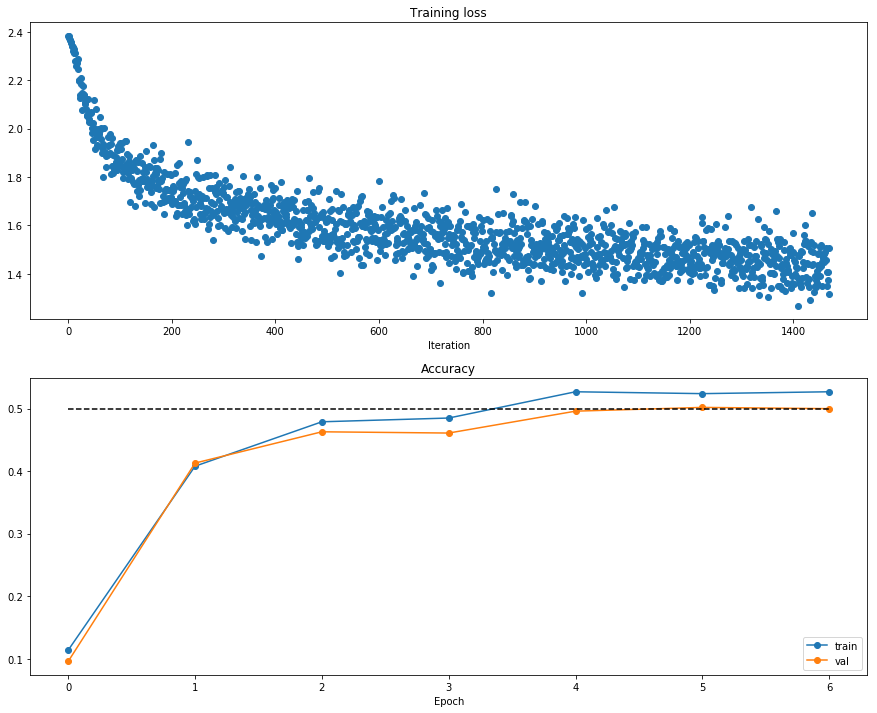

In [11]:
# Execute esta célula para visualizar a perda durante o treinamento e a acurácia
# tanto sobre o conjunto de treinamento quanto sobre o conjunto de validação.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Redes Multicamadas

A seguir, você irá implementar e testar uma rede completamente conectada com um número arbitrário de camadas.

Leia e estude a implementação da classe `FullyConnectedNet` no arquivo `dl/classifiers/fc_net.py`.

Você deve se preocupar com a implementação da inicialização, bem como do *forward pass* e do *backward pass*. Por enquanto, não se preocupe com a implementação de *dropout* ou de *batch normalization*, pois você irá explorar essas técnicas em outras atividades mais adiante.

## Perda Inicial e Verificação de Gradiente

Com intuito de realizar uma simples verificação, você deve executar o seguinte código para checar a perda inicial e o gradiente da rede sem e com regularização.

Os valores de perda inicial lhe parecem razoáveis?

Para a verificação de gradiente, você deve esperar erros em torno de 1e-6 ou menos.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


Para uma outra verificação simples, você deve tentar realizar um "sobreajuste" (*overfitting*) de um pequeno conjunto com 50 imagens. Primeiramente, você deve experimentar com uma rede de três camadas com 100 unidades em cada camada escondida. **Você precisará ajustar a taxa de aprendizado e a escala de inicialização**, porém você deve ser capaz de "sobreajustar" seu modelo e alcançar 100% de acurácia no treinamento dentro de 20 épocas.

(Iteration 1 / 40) loss: 12.156330
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.127000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.133000
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.151000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.149000
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.140000
(Iteration 11 / 40) loss: 0.711825
(Epoch 6 / 20) train acc: 0.800000; val_acc: 0.148000
(Epoch 7 / 20) train acc: 0.700000; val_acc: 0.158000
(Epoch 8 / 20) train acc: 0.780000; val_acc: 0.148000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.135000
(Epoch 10 / 20) train acc: 0.860000; val_acc: 0.142000
(Iteration 21 / 40) loss: 0.184583
(Epoch 11 / 20) train acc: 0.880000; val_acc: 0.140000
(Epoch 12 / 20) train acc: 0.920000; val_acc: 0.146000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.145000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.147000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.149000
(Iteration 31 / 40) loss:

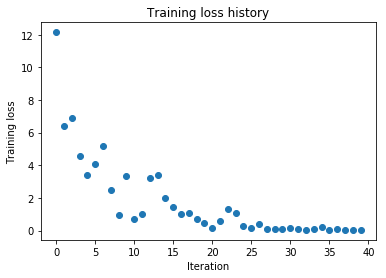

In [15]:
# TODO: Usar uma rede de 3-camadas para "sobreajustar" (overfit) 50 exemplos de treinamento.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 4e-2    # experimente variar entre 1e-2 e 5e-2
learning_rate = 3e-4   # experimente variar entre 1e-4 e 5e-4

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={'learning_rate': learning_rate,}
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Agora, você deve usar uma rede de cinco camadas com 100 unidades em cada camada para fazer o sobreajuste (*overfitting*) de 50 exemplos de treinamento.
**Novamente, você deverá ajustar a taxa de aprendizado e a escala de inicialição de pesos**, porém você deve conseguir alcançar 100% de acurácia dentro de 20 épocas. 

(Iteration 1 / 40) loss: 111.842476
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.090000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.104000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.094000
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.108000
(Epoch 4 / 20) train acc: 0.780000; val_acc: 0.107000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.125000
(Iteration 11 / 40) loss: 2.034630
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.125000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.123000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.122000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.123000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.123000
(Iteration 21 / 40) loss: 0.495806
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.117000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.117000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.117000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.117000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.117000
(Iteration 31 / 40) loss

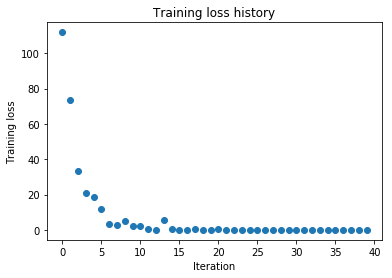

In [19]:
# TODO: Usar uma rede de 5-camadas para "sobreajustar" (overfit) 50 exemplos de treinamento.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1    # experimente variar entre 1e-2 e 1e-1
learning_rate = 5e-4   # experimente variar entre 1e-5 e 1e-3

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={'learning_rate': learning_rate,}
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Pergunta #1: 
O que você observou sobre a dificuldade de se treinar a rede de 3-camadas em comparação com o treinamento da rede de 5-camadas?

# Resposta:
A rede de 3 camadas é um pouco mais fácil de se treinar em relação à rede de 5 camadas.


# Regras de Atualização

Até então, você tem utilizado apenas o método de descida mais íngreme estocástico (SGD - *stochastic gradient descent*) como regra de atualização. O uso de regras de atualização mais sofisticadas pode facilitar o treinamento de redes profundas. A seguit, você irá implementar outras regras de atualização comuns na atualidade e comparar seus resultados com os obtidos pelo SGD básico.

## Regra de Atualização: SGD + Momento

SGD com momento é amplamente utilizando como regra de atualização e tende a fazer com que o treinamento de redes profundas obtenha convergência mais rápido do que quando utilizado apenas o SGD. 

Abra o arquivo `dl/optim.py` e leia a documentação no início do arquivo de forma a garantir que você tenha compreendido a API.

Em seguida, você deve implementar a regra de atualização SGD+momento usando a função `sgd_momentum` e executar o seguinte código para verificar sua implementação. 

Você deve observer erros menores que 1e-8.

In [21]:
from dl.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Uma vez que você tenha implementado a nova regra de atualização, execute o seguinte código para treinamento de uma rede de 6-camadas utilizando tanto a regra básica SGD como a nova SGA+momento.

Você deve ver que a regra de atualização SGD+momento consegue obter uma convergência mais rápida. 

running with  sgd
(Iteration 1 / 200) loss: 3.018624
(Epoch 0 / 5) train acc: 0.112000; val_acc: 0.102000
(Iteration 11 / 200) loss: 2.283175
(Iteration 21 / 200) loss: 2.176841
(Iteration 31 / 200) loss: 2.052072
(Epoch 1 / 5) train acc: 0.310000; val_acc: 0.266000
(Iteration 41 / 200) loss: 1.910733
(Iteration 51 / 200) loss: 2.042434
(Iteration 61 / 200) loss: 1.912792
(Iteration 71 / 200) loss: 1.816943
(Epoch 2 / 5) train acc: 0.330000; val_acc: 0.295000
(Iteration 81 / 200) loss: 1.746582
(Iteration 91 / 200) loss: 1.759920
(Iteration 101 / 200) loss: 1.805070
(Iteration 111 / 200) loss: 1.800427
(Epoch 3 / 5) train acc: 0.370000; val_acc: 0.297000
(Iteration 121 / 200) loss: 1.644111
(Iteration 131 / 200) loss: 1.690391
(Iteration 141 / 200) loss: 1.738817
(Iteration 151 / 200) loss: 1.671138
(Epoch 4 / 5) train acc: 0.440000; val_acc: 0.331000
(Iteration 161 / 200) loss: 1.780751
(Iteration 171 / 200) loss: 1.784588
(Iteration 181 / 200) loss: 1.639889
(Iteration 191 / 200) los

/home/falreis/miniconda2/envs/i2dl_tp2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


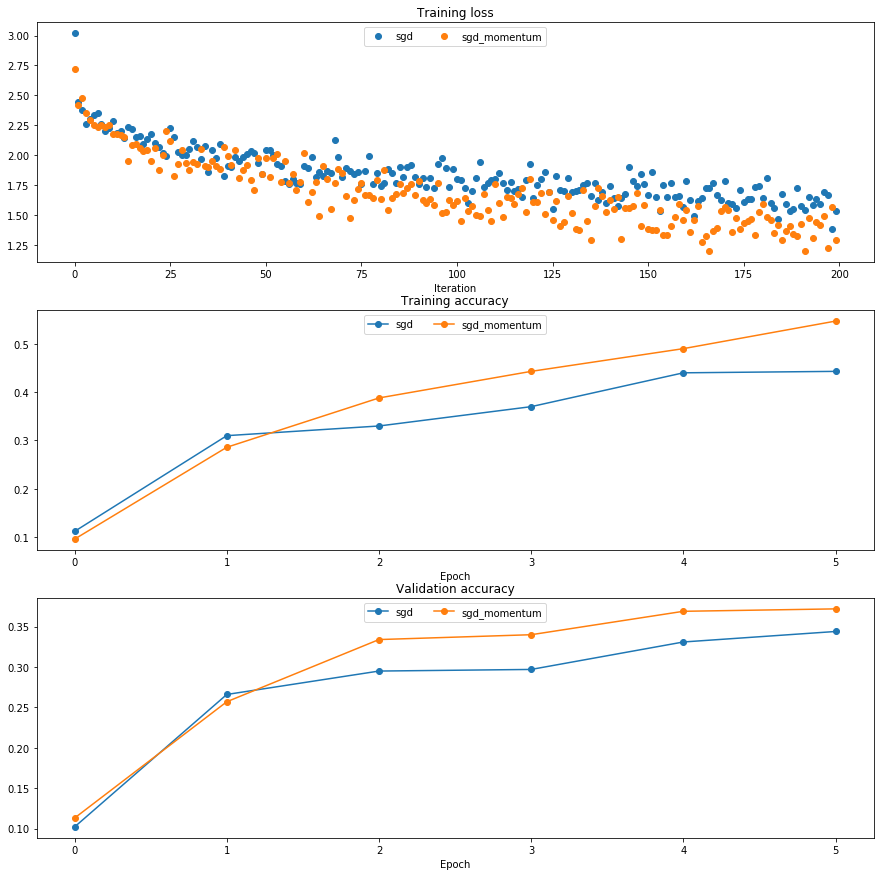

In [22]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

## Outras Regras de Atualização: RMSProp e Adam

RMSProp [1] e Adam [2] são regras de atualização que ajustam as taxas de aprendizagem por parâmetros usando uma média móvel dos momentos de segunda ordem dos graduentes.

No arquivo `dl/optim.py`, você deverá implementar a regra RMSProp na função `rmsprop` e regra Adam na função `adam`. Em seguida, você poderá checar suas implementações usando o código abaixo.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [25]:
# Teste da implementação de RMSProp; você deve observar erros menores que 1e-7
from dl.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [26]:
# Teste da implementação de Adam; você deve observar erros em torno de 1e-7 ou menos
from dl.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.139887467333134e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Uma vez que você tenha testado e depurado suas implementações das regras RMSProp e Adam, execute o seguinte código para treinar redes profundas utilizando estas novas regras:

running with  adam
(Iteration 1 / 200) loss: 2.618083
(Epoch 0 / 5) train acc: 0.120000; val_acc: 0.125000
(Iteration 11 / 200) loss: 2.047675
(Iteration 21 / 200) loss: 1.882624
(Iteration 31 / 200) loss: 1.797980
(Epoch 1 / 5) train acc: 0.366000; val_acc: 0.329000
(Iteration 41 / 200) loss: 1.767055
(Iteration 51 / 200) loss: 1.565953
(Iteration 61 / 200) loss: 1.806655
(Iteration 71 / 200) loss: 1.535777
(Epoch 2 / 5) train acc: 0.439000; val_acc: 0.360000
(Iteration 81 / 200) loss: 1.698089
(Iteration 91 / 200) loss: 1.559168
(Iteration 101 / 200) loss: 1.501367
(Iteration 111 / 200) loss: 1.419027
(Epoch 3 / 5) train acc: 0.515000; val_acc: 0.373000
(Iteration 121 / 200) loss: 1.536067
(Iteration 131 / 200) loss: 1.260942
(Iteration 141 / 200) loss: 1.512189
(Iteration 151 / 200) loss: 1.362687
(Epoch 4 / 5) train acc: 0.528000; val_acc: 0.379000
(Iteration 161 / 200) loss: 1.303992
(Iteration 171 / 200) loss: 1.277162
(Iteration 181 / 200) loss: 1.118395
(Iteration 191 / 200) lo

/home/falreis/miniconda2/envs/i2dl_tp2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


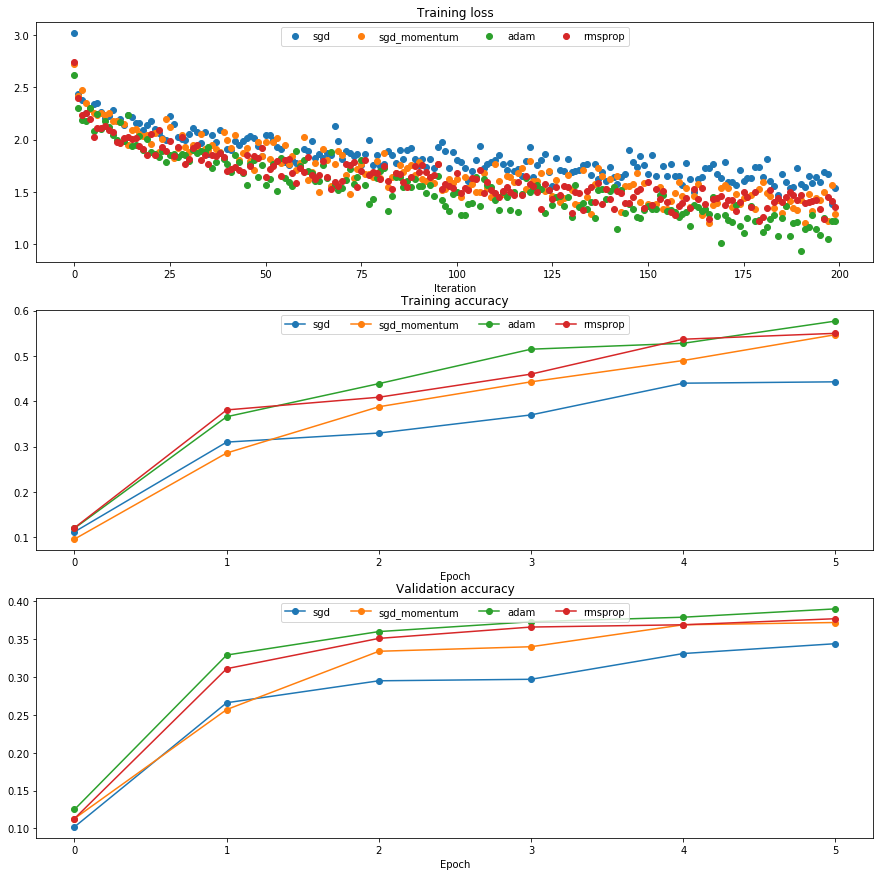

In [27]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                    num_epochs=5, batch_size=100,
                    update_rule=update_rule,
                    optim_config={
                    'learning_rate': learning_rates[update_rule]
                    },
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Treinar um bom modelo!

Agora, você deverá treinar o melhor modelo (completamente conectado) que conseguir sobre a base de dados CIFAR-10, armazenando seu melhor modelo na variável `best_model`. Você deverá ser capar de obter pelo menos 50% de acurácia sobre o conjunto de validação utilizando uma rede completamente conectada.

Se você for cuidadoso, é possível se obter acurácias acima de 55%, porém isto não é necessário neste momento e você não receberá pontos extras se o fizer. Mais adiante, você será estimulado a treinar a melhor rede convolucional que conseguir sobre a bass de dados CIFAR-10 e, portanto, é melhor que você use seu esforços trabalhando com redes convolucionais do que com redes completamente conectadas.

Talvez você ache útil completar os próximos dois notebooks (`02-BatchNormalization.ipynb` e `03-Dropout.ipynb`) antes de completar esta parte, uma vez que essas técnicas podem ajudá-lo a treinar modelos mais poderosos.

In [48]:
best_model = None
################################################################################
# TODO: Treinar o melhor modelo que você conseguir usando a classe             #
# FullyConnectedNet sobre a base de dados CIFAR-10. Você talvez ache útil usar #
# as técnicas de "batch normalization" e "dropout" para isso.                  #
# Ao final, você deve armazenar o melhor modelo na variável "best_model".      #
################################################################################
best_model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(best_model
                , data
                , num_epochs=10
                , batch_size=250
                , update_rule='adam'
                , optim_config={'learning_rate': 1e-3}
                , print_every=500
                , verbose=True
               )
solver.train()
################################################################################
#                             FIM DE SEU CÓDIGO                                #
################################################################################

(Iteration 1 / 1960) loss: 2.680630
(Epoch 0 / 10) train acc: 0.140000; val_acc: 0.122000
(Epoch 1 / 10) train acc: 0.457000; val_acc: 0.428000
(Epoch 2 / 10) train acc: 0.470000; val_acc: 0.453000
(Iteration 501 / 1960) loss: 1.414258
(Epoch 3 / 10) train acc: 0.540000; val_acc: 0.485000
(Epoch 4 / 10) train acc: 0.544000; val_acc: 0.486000
(Epoch 5 / 10) train acc: 0.546000; val_acc: 0.491000
(Iteration 1001 / 1960) loss: 1.210936
(Epoch 6 / 10) train acc: 0.584000; val_acc: 0.510000
(Epoch 7 / 10) train acc: 0.567000; val_acc: 0.490000
(Iteration 1501 / 1960) loss: 1.208467
(Epoch 8 / 10) train acc: 0.580000; val_acc: 0.513000
(Epoch 9 / 10) train acc: 0.619000; val_acc: 0.497000
(Epoch 10 / 10) train acc: 0.589000; val_acc: 0.506000


# Testar seu modelo

Executar o melhor modelo obtido anteriormente sobre os conjuntos de validação e de teste.
Voce deve ter alcançado um resultado acima de 50% de acurácia sobre o conjunto de validação.

In [49]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.513
Test set accuracy:  0.501
